In [2]:
#import modules
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gsw
from pkg_resources import non_empty_lines
import os
import glob
from matplotlib.lines import Line2D
import re

In [3]:
data_dir = '/Users/iw2g24/PycharmProjects/COOKIES/Data/'
v01_2024_dir = data_dir + 'IDC_IN2024_V01_ctd_5504/IN2024_V01_CTD_CtdAvg_nc/'
# Find all NetCDF files
files = glob.glob(os.path.join(v01_2024_dir,'in2024_v01*.nc'))

files = sorted(
    files,
    key=lambda f: int(re.search(r'v(\d+)CtdAvg', os.path.basename(f)).group(1))
)


# datasets = {}
# stations_all = []
#
# for file_name in files:
#     base = os.path.basename(file_name)
#
#     # Extract the numeric block between 'v' and 'CtdAvg'
#     match = re.search(r'v(\d+)CtdAvg', base)
#     if not match:
#         raise ValueError(f"Could not extract station number from filename: {base}")
#
#     stn = match.group(1)   # e.g., "01001"
#
#     stations_all.append(stn)
#     datasets[stn] = xr.open_dataset(file_name, decode_timedelta=False)
#
#     print(f"Opened dataset for station {stn}")

datasets = {}
stations_all = []

for file_name in files:
    base = os.path.basename(file_name)

    # Extract numeric ID between v and CtdAvg
    stn = re.search(r'v(\d+)CtdAvg', base).group(1)

    stations_all.append(stn)
    datasets[stn] = xr.open_dataset(file_name, decode_timedelta=False)

    # print(f"Opened dataset for station {stn}")

In [9]:

ds_028 = datasets['01028']
data = ds_028
print(list(ds_028))
print(list(ds_028.coords))

['woce_date', 'woce_time', 'temperature', 'temperatureFlag', 'conductivity', 'conductivityFlag', 'salinity', 'salinityFlag', 'temperature_2', 'temperature_2Flag', 'conductivity_2', 'conductivity_2Flag', 'salinity_2', 'salinity_2Flag', 'oxygen', 'oxygenFlag', 'oxygen_2', 'oxygen_2Flag', 'altimeter', 'altimeterFlag', 'par', 'parFlag', 'transmissometer', 'transmissometerFlag', 'fluorometer', 'fluorometerFlag', 'obs', 'obsFlag']
['time', 'pressure', 'latitude', 'longitude']


In [10]:
print(list(ds_028.coords['time'].values))

[np.datetime64('2024-01-26T21:52:42.335000064')]


In [11]:
mean_lon = []
mean_lat = []

for stn in stations_all:
    ds = datasets[stn]

    # Extract coordinates
    lon = ds.coords["longitude"].values
    lat = ds.coords["latitude"].values
    pressure = ds.coords["pressure"].values   # <-- FIXED

    # # Apply mask
    # mask = pressure > 8.5
    # longitude = lon[mask]
    # latitude = lat[mask]

    lon_mean = np.mean(lon)
    lat_mean = np.mean(lat)

    mean_lon.append(lon_mean)
    mean_lat.append(lat_mean)

    print(f"Mean lon/lat at {stn}: {lon_mean:.4f} / {lat_mean:.4f}")


Mean lon/lat at 01001: 148.1173 / -43.5506
Mean lon/lat at 01002: 142.6657 / -46.6654
Mean lon/lat at 01003: 149.9939 / -62.5025
Mean lon/lat at 01004: 150.0020 / -63.0015
Mean lon/lat at 01005: 150.0104 / -63.4940
Mean lon/lat at 01006: 150.0032 / -63.9995
Mean lon/lat at 01007: 150.0003 / -64.5002
Mean lon/lat at 01008: 149.9968 / -65.0112
Mean lon/lat at 01009: 150.0027 / -65.3418
Mean lon/lat at 01010: 144.9475 / -66.4765
Mean lon/lat at 01011: 144.1918 / -66.7001
Mean lon/lat at 01012: 145.0021 / -67.0018
Mean lon/lat at 01013: 139.9964 / -65.5315
Mean lon/lat at 01014: 139.9993 / -65.4000
Mean lon/lat at 01015: 140.0010 / -65.3856
Mean lon/lat at 01016: 139.9947 / -65.3997
Mean lon/lat at 01017: 140.0053 / -65.0000
Mean lon/lat at 01018: 140.0058 / -64.5481
Mean lon/lat at 01019: 140.0026 / -64.2129
Mean lon/lat at 01020: 140.0026 / -63.8722
Mean lon/lat at 01021: 140.0043 / -63.3511
Mean lon/lat at 01022: 139.9988 / -62.8530
Mean lon/lat at 01023: 132.0022 / -62.0001
Mean lon/la

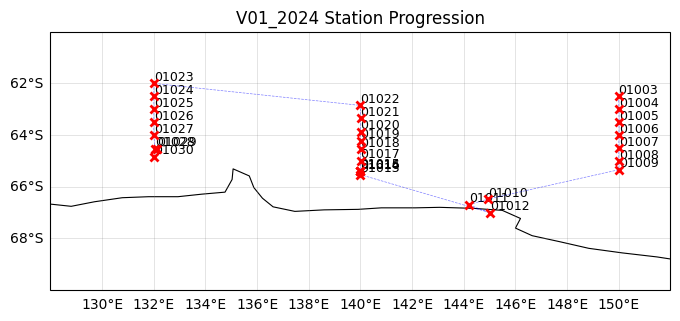

In [7]:
proj = ccrs.PlateCarree()

lon_min, lon_max = 128, 152
lat_min, lat_max = -60, -70

fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=proj)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs = proj)

# Coastlines
ax.coastlines(resolution='110m', linewidth=0.8)

mean_lon = np.array(mean_lon)
mean_lat = np.array(mean_lat)
stations_all = np.array(stations_all)

mask = (
    (mean_lat <= lat_min) & (mean_lat >= lat_max) &
    (mean_lon >= lon_min) & (mean_lon <= lon_max)
)

mean_lon_plot = mean_lon[mask]
mean_lat_plot = mean_lat[mask]
stations_plot = stations_all[mask]


# Line (transparent)
ax.plot(
    mean_lon_plot,
    mean_lat_plot,
    linestyle='--',
    color='blue',
    linewidth=0.5,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
    zorder=4
)

# Markers (fully opaque)
ax.plot(
    mean_lon_plot,
    mean_lat_plot,
    linestyle='None',
    marker='x',
    color='red',
    markersize=6,
    markeredgewidth=2,
    transform=ccrs.PlateCarree(),
    zorder=5
)

# stations = ['001', '002', '003', '004', '005', '006', '007', '008', '009','010', '011', '012', '013']

# Label stations
for stn, lon, lat in zip(stations_plot, mean_lon_plot, mean_lat_plot):
    ax.text(
        lon, lat, stn,
        transform=ccrs.PlateCarree(),
        fontsize=9,
        ha='left',
        va='bottom'
    )

# -------------------------
# Gridlines + lon/lat ticks
# -------------------------
lon_ticks = np.arange(-180, 181, 2)   # adjust spacing as needed
lat_ticks = np.arange(-90, 91, 2)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.3,
    linestyle='-',
    xlocs=lon_ticks,
    ylocs=lat_ticks
)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_ylim(lat_max, lat_min)

ax.set_title("V01_2024 Station Progression")

plt.show()


In [8]:
mean_lon = []
mean_lat = []

line_132 = ['01023', '01024', '01025', '01026', '01027', '01028', '01029', '01030']

for stn in line_132:
    ds = datasets[stn]

    # Extract coordinates
    lon = ds.coords["longitude"].values
    lat = ds.coords["latitude"].values
    pressure = ds.coords["pressure"].values   # <-- FIXED

    # # Apply mask
    # mask = pressure > 8.5
    # longitude = lon[mask]
    # latitude = lat[mask]

    lon_mean = np.mean(lon)
    lat_mean = np.mean(lat)

    mean_lon.append(lon_mean)
    mean_lat.append(lat_mean)

    print(f"Mean lon/lat at {stn}: {lon_mean:.4f} / {lat_mean:.4f}")


Mean lon/lat at 01023: 132.0022 / -62.0001
Mean lon/lat at 01024: 132.0032 / -62.5000
Mean lon/lat at 01025: 132.0012 / -63.0015
Mean lon/lat at 01026: 132.0011 / -63.5010
Mean lon/lat at 01027: 131.9981 / -64.0012
Mean lon/lat at 01028: 132.0513 / -64.5211
Mean lon/lat at 01029: 132.1247 / -64.5235
Mean lon/lat at 01030: 131.9942 / -64.8403
